In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt
from sklearn import metrics
from torchvision import transforms
from dataset import CatDog
from model import DogvsCatModel
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose(
    [
        transforms.Resize(size=(128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

cuda


In [3]:
fullData = CatDog(root="CATDOG/train/", transform=transform)
N = len(fullData)
trainL = int(0.99 * N)
testL = N - trainL

trainData, testData = data.random_split(fullData, [trainL, testL])
trainLoader = data.DataLoader(dataset=trainData, batch_size=8, shuffle=True)
testLoader = data.DataLoader(dataset=testData, batch_size=testL)
testX, testY = next(iter(testLoader))
testX = testX.to(device)
testY = testY.type(torch.float).to(device)

In [4]:
model = DogvsCatModel().to(device)
optim = torch.optim.Adam(params=model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [5]:
history = [[],[]]
minValLoss = np.inf
for _ in range(1):
    for trainX, trainY in trainLoader:
        model.train()
        trainX = trainX.to(device)
        trainY = trainY.type(torch.float).to(device)

        pred = model(trainX).squeeze(1)
        loss = criterion(pred, trainY)
        loss.backward()
        optim.step()
        optim.zero_grad()
        with torch.no_grad():
            model.eval()
            pred = model(testX).squeeze(1)
            val_loss = criterion(pred, testY)
        history[0].append(loss.item())
        history[1].append(val_loss.item())
        if val_loss.item() <= minValLoss:
            minValLoss = val_loss.item()
            torch.save(model, "checkpoint.pt")

/home/ykc/dev/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


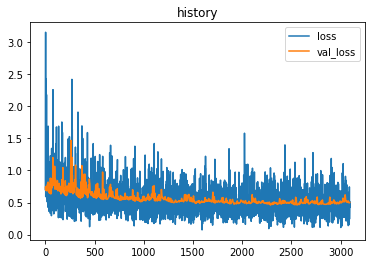

In [6]:
plt.plot(history[0], label="loss")
plt.plot(history[1], label="val_loss")
plt.legend()
plt.title("history")
plt.show()

In [7]:
model = torch.load("checkpoint.pt")
testY = testY.cpu().numpy()
with torch.no_grad():
    model.eval()
    pred = model(testX)
    pred = torch.round(pred).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.776


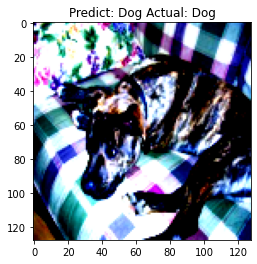

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


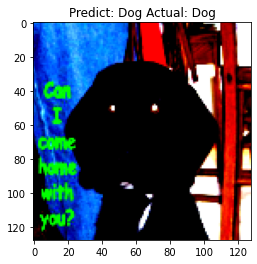

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


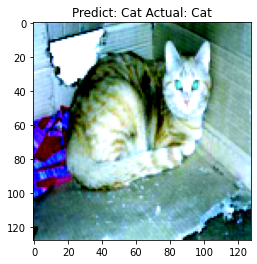

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


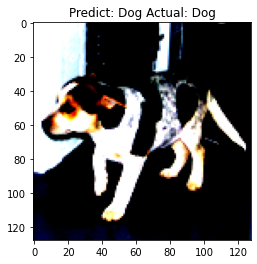

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


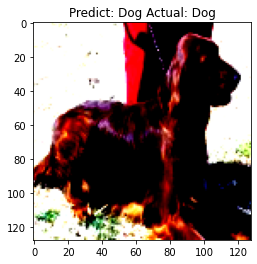

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


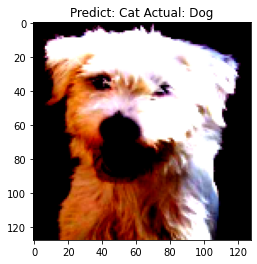

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


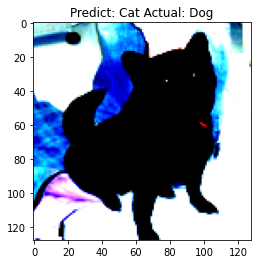

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


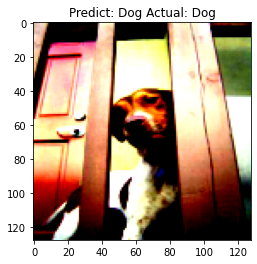

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


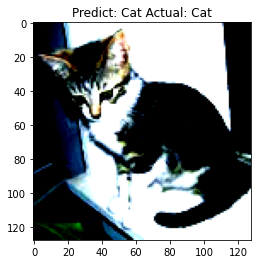

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


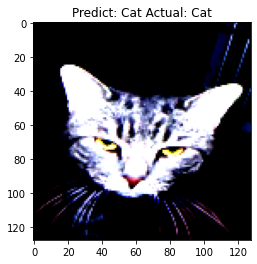

In [8]:
print(metrics.accuracy_score(pred, testY))
for i in range(10):
    plt.imshow(testX[i].permute(1, 2, 0).cpu().numpy())
    P = "Cat" if pred[i] == 0 else "Dog"
    A = "Cat" if testY[i] == 0 else "Dog"
    plt.title(f"Predict: {P} Actual: {A}")
    plt.show()

In [9]:
testData = CatDog(root="CATDOG/test1/", transform=transform)
testLoader = data.DataLoader(dataset=testData, batch_size=8)
model = torch.load("checkpoint.pt").to(device)
model.eval()
result = []
for x, y in testLoader:
    x = x.to(device)
    with torch.no_grad():
        model.eval()
        pred = model(x)
        pred = torch.round(pred).cpu().numpy()
        result.append(pred)
        
result = np.concatenate(result, axis=0)

In [10]:
submissions = pd.DataFrame({"label": result.reshape(-1)})
submissions.index += 1
submissions.to_csv("submissions.csv", index_label="id")